# Recurrent Neural Nets: A Minimal Demo

- A minimal introduction to recurrent neural nets
- We'll apply to a simple synthetic dataset

In [1]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [6]:
from datetime import datetime

 #end="2023-04-01")

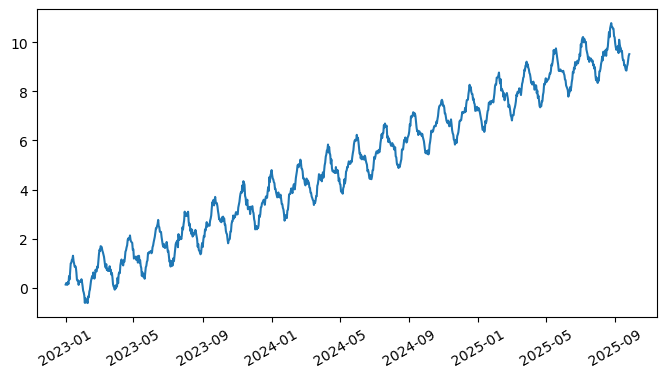

In [286]:
#Make a synthetic time-series:
#####

N = 1000

#x ranges 0 to N-1
x = np.arange(0, N)

#Make a list of N days:
dates = pd.date_range(start="2023-01-01", periods=N).to_list()

#Get a y values:
#y = np.arange(0, N) #
y = np.sin((x/8))**3 + .01*x + np.random.normal(loc=0, scale=.1, size=N)

#Plot our data:
fig, ax1 = plt.subplots(1,1, figsize=(8,4))

ax1.plot(dates, y, '-', markersize=4);
ax1.set_xticks(ax1.get_xticks(), labels=ax1.get_xticklabels(), rotation=30);

#ax1.set_xticklabels(dates, rotation=45)

In [287]:
#Put it into a DataFrame:
#########

df = pd.DataFrame({'y':y}, index=dates)
df

,y
2023-01-01,0.124903
2023-01-02,0.184831
2023-01-03,0.178834
2023-01-04,0.113289
2023-01-05,0.227787
...,...
2025-09-22,9.023129
2025-09-23,9.100146
2025-09-24,9.283598
2025-09-25,9.458086


In [288]:
#Split data into training, validation, and testing groups:
df_train = df["y"]["2023-01-01":"2025-06-01"]
df_valid = df["y"]["2025-06-01":]
#df_test = df["y"][...]

In [290]:
seq_length = 16

#Now convert to a keras/tf time-series dataset:
#######

#Create a dataset of all windows of size seq_length, with a 
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    df_train.to_numpy(),
    targets=df_train[seq_length:], #Targets are seq_length into the future
    sequence_length=seq_length,
    batch_size=32,
    shuffle=False,
    seed=42
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    df_valid.to_numpy(),
    targets=df_valid[seq_length:], #Targets are seq_length into the future
    sequence_length=seq_length,
    batch_size=32
)

In [291]:
list(train_ds)

[(<tf.Tensor: shape=(32, 16), dtype=float64, numpy=
  array([[ 0.12490257,  0.18483089,  0.17883377,  0.11328943,  0.22778677,
           0.1441566 ,  0.46773538,  0.33190199,  0.68904952,  0.99032578,
           1.00857848,  1.13212622,  1.16172071,  1.29922959,  1.08554615,
           0.97989458],
         [ 0.18483089,  0.17883377,  0.11328943,  0.22778677,  0.1441566 ,
           0.46773538,  0.33190199,  0.68904952,  0.99032578,  1.00857848,
           1.13212622,  1.16172071,  1.29922959,  1.08554615,  0.97989458,
           0.8522818 ],
         [ 0.17883377,  0.11328943,  0.22778677,  0.1441566 ,  0.46773538,
           0.33190199,  0.68904952,  0.99032578,  1.00857848,  1.13212622,
           1.16172071,  1.29922959,  1.08554615,  0.97989458,  0.8522818 ,
           0.8777633 ],
         [ 0.11328943,  0.22778677,  0.1441566 ,  0.46773538,  0.33190199,
           0.68904952,  0.99032578,  1.00857848,  1.13212622,  1.16172071,
           1.29922959,  1.08554615,  0.97989458,  0

In [292]:
#Forecast using linear model:
#####

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])

#Use Huber Loss
model.compile(loss=tf.keras.losses.Huber(), optimizer='sgd', metrics=["mae"])

history = model.fit(train_ds, validation_data=valid_ds, epochs=10, verbose=False)

<Axes: >

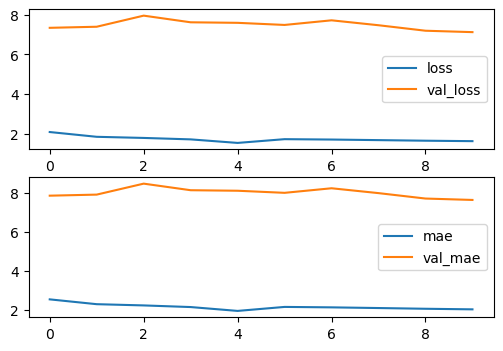

In [293]:
hist_df = pd.DataFrame(history.history)

fig, ax1 = plt.subplots(2,1, figsize=(6,4))

hist_df[['loss', 'val_loss']].plot(ax=ax1[0])
hist_df[['mae', 'val_mae']].plot(ax=ax1[1])

28/28 [==============================] - 1s 19ms/step


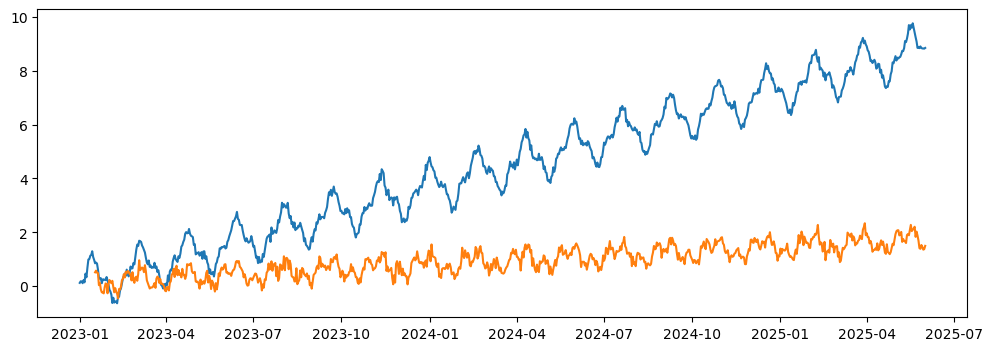

In [294]:
y_hat = model.predict(train_ds)

fig, ax1 = plt.subplots(1,1, figsize=(12,4))

ax1.plot(df_train.index, df_train.to_numpy())
ax1.plot(df_train.iloc[seq_length:].index, y_hat.flatten())

4/4 [==============================] - 0s 2ms/step - loss: 7.1269 - mae: 7.6269


[7.126931667327881, 7.626931667327881]

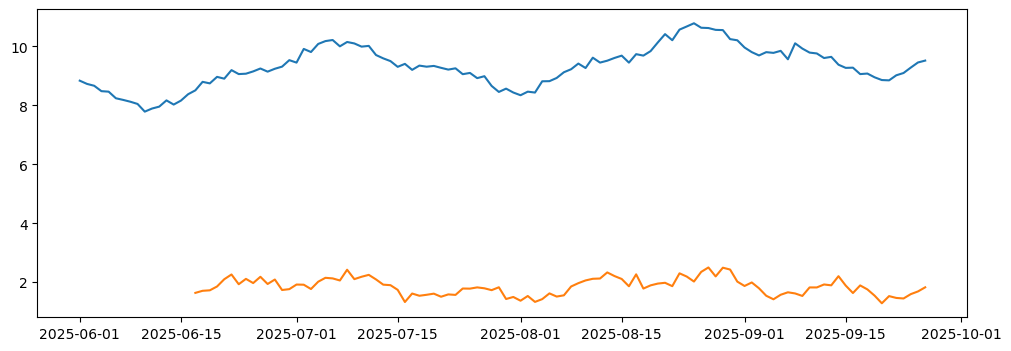

In [295]:

y_hat = model.predict(valid_ds)

fig, ax1 = plt.subplots(1,1, figsize=(12,4))

ax1.plot(df_valid.index, df_valid.to_numpy())
ax1.plot(df_valid.iloc[seq_length:].index, y_hat.flatten())

model.evaluate(valid_ds)

### Now use minimal RNN:

In [318]:
#Note default activation function for RNN is tanh
#Output bounded between -1 and 1
#Train long enough with the Dense layer and it will work
model_rnn = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1]),
    tf.keras.layers.Dense(1) #Can add for more output range
])

In [325]:
#Can try with a LSTM cell instead:
#model_rnn = tf.keras.Sequential([
#    tf.keras.layers.LSTM(1, input_shape=[None, 1]),
#    tf.keras.layers.Dense(1) #Add for more output range
#])

In [337]:
#Or, a little more complex:
model_rnn = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)
])

In [338]:
#Use Huber Loss
model_rnn.compile(loss=tf.keras.losses.Huber(), optimizer='nadam', metrics=["mae"])

history = model_rnn.fit(train_ds, validation_data=valid_ds, epochs=10, verbose=False)

<Axes: >

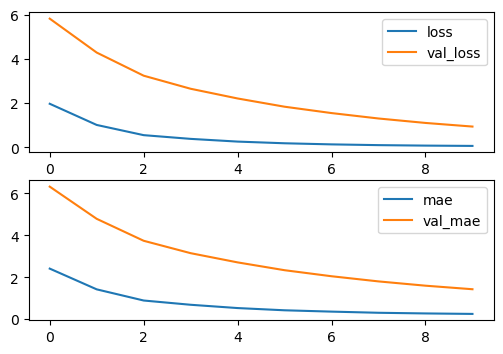

In [339]:
hist_df = pd.DataFrame(history.history)

fig, ax1 = plt.subplots(2,1, figsize=(6,4))

hist_df[['loss', 'val_loss']].plot(ax=ax1[0])
hist_df[['mae', 'val_mae']].plot(ax=ax1[1])

28/28 [==============================] - 0s 1ms/step


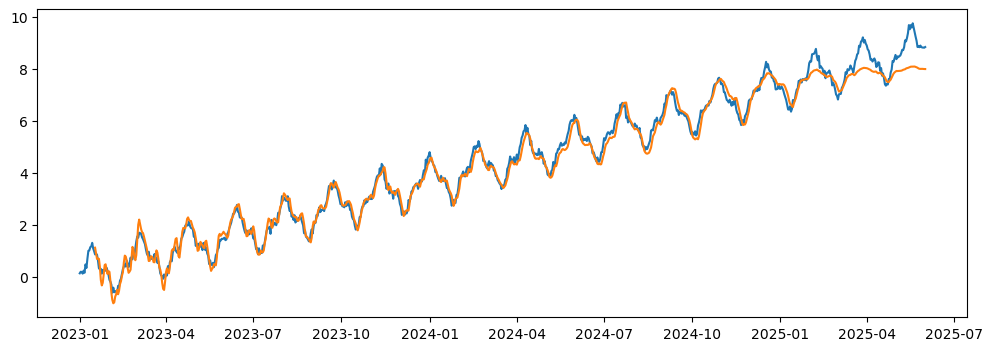

In [340]:
y_hat = model_rnn.predict(train_ds)

fig, ax1 = plt.subplots(1,1, figsize=(12,4))

ax1.plot(df_train.index, df_train.to_numpy())
ax1.plot(df_train.iloc[seq_length:].index, y_hat.flatten())

4/4 [==============================] - 0s 18ms/step - loss: 0.0504 - mae: 0.2319


[0.05040824040770531, 0.23185765743255615]

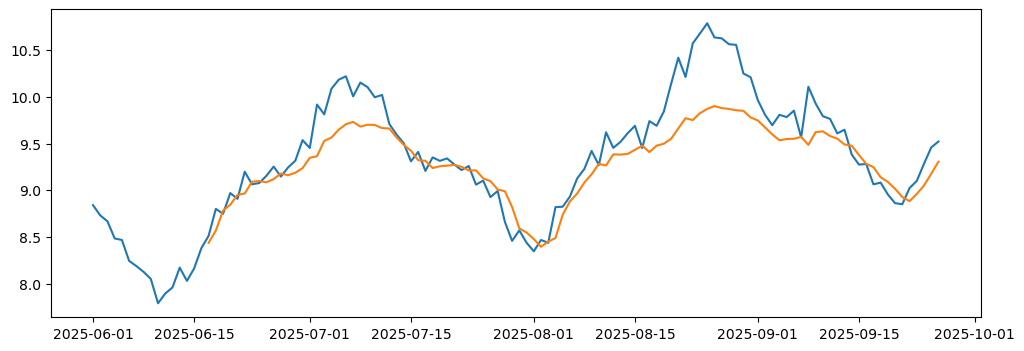

In [307]:

y_hat = model_rnn.predict(valid_ds)

fig, ax1 = plt.subplots(1,1, figsize=(12,4))

ax1.plot(df_valid.index, df_valid.to_numpy())
ax1.plot(df_valid.iloc[seq_length:].index, y_hat.flatten())

model_rnn.evaluate(valid_ds)

### And a Deep RNN:

In [308]:
model_deep = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [309]:
#Use Huber Loss
model_deep.compile(loss=tf.keras.losses.Huber(), optimizer='nadam', metrics=["mae"])

history = model_deep.fit(train_ds, validation_data=valid_ds, epochs=100, verbose=False)

<Axes: >

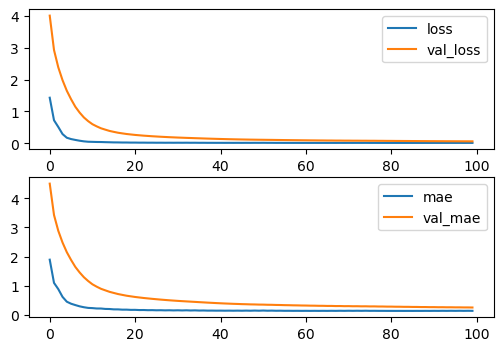

In [310]:
hist_df = pd.DataFrame(history.history)

fig, ax1 = plt.subplots(2,1, figsize=(6,4))

hist_df[['loss', 'val_loss']].plot(ax=ax1[0])
hist_df[['mae', 'val_mae']].plot(ax=ax1[1])

28/28 [==============================] - 0s 2ms/step


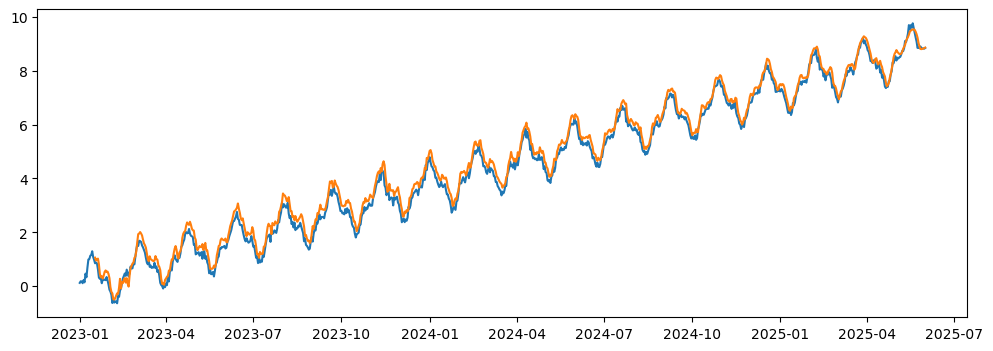

In [311]:
y_hat = model_deep.predict(train_ds)

fig, ax1 = plt.subplots(1,1, figsize=(12,4))

ax1.plot(df_train.index, df_train.to_numpy())
ax1.plot(df_train.iloc[seq_length:].index, y_hat.flatten())

4/4 [==============================] - 0s 17ms/step - loss: 0.0625 - mae: 0.2477


[0.06252267211675644, 0.24769887328147888]

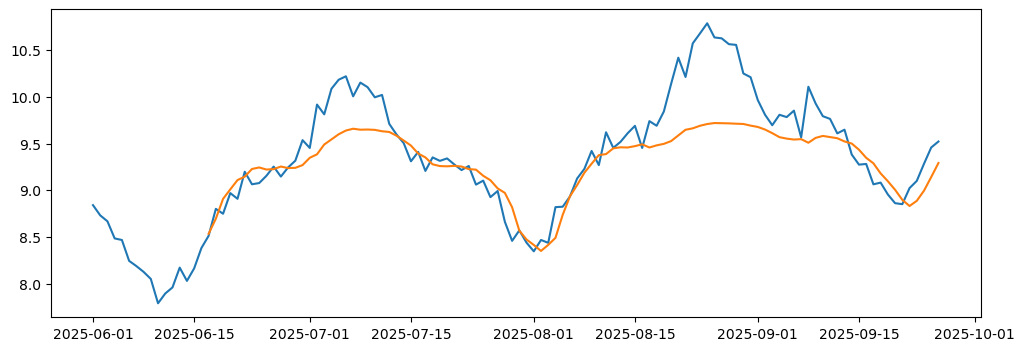

In [313]:

y_hat = model_deep.predict(valid_ds)

fig, ax1 = plt.subplots(1,1, figsize=(12,4))

ax1.plot(df_valid.index, df_valid.to_numpy())
ax1.plot(df_valid.iloc[seq_length:].index, y_hat.flatten())

model_deep.evaluate(valid_ds)